In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/content/drive/MyDrive/Colab_Notebooks/balanced_dataset_final.csv"

df = dk.read_csv(file_path)

label
6    2634124
4    2999996
0    1098195
Name: count, dtype: int64


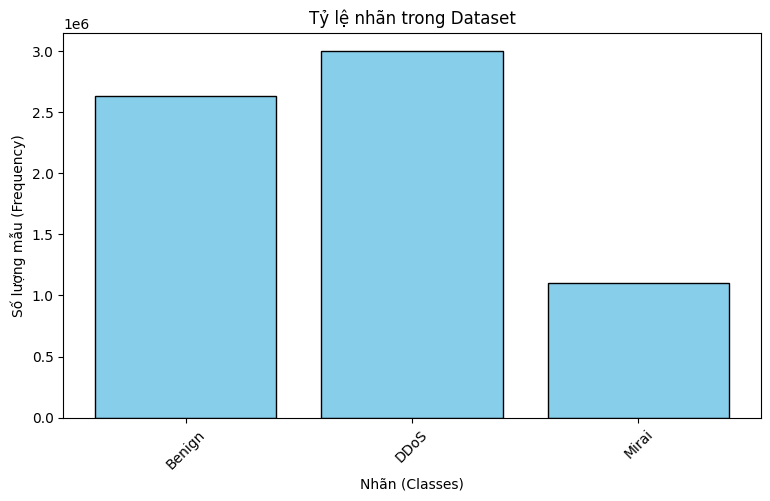

In [5]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood',
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["Benign","DDoS","Mirai"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [3]:
import pandas as pd
import os
import time
import shutil
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
import psutil
import gc

def process_large_dataset(input_csv, output_csv, target_ddos=2000000, chunk_size=20000):
    print("Bắt đầu xử lý dataset cực lớn...")
    start_time = time.time()

    # Tạo thư mục tạm với timestamp để tránh trùng lặp
    temp_dir = f"temp_chunks_{int(time.time())}"
    os.makedirs(temp_dir, exist_ok=True)

    def print_memory_usage():
        """In thông tin sử dụng RAM hiện tại."""
        memory = psutil.virtual_memory()
        print(f"RAM used: {memory.used / (1024 ** 3):.2f} GB / {memory.total / (1024 ** 3):.2f} GB")

    try:
        # Khởi tạo StandardScaler
        scaler = StandardScaler()

        # 1. Đếm tổng số mẫu DDoS
        print("Đang đếm tổng số mẫu DDoS...")
        total_ddos = 0
        for chunk in pd.read_csv(input_csv, chunksize=chunk_size):
            total_ddos += len(chunk[chunk['label'] == 4])
        print(f"Tổng số mẫu DDoS: {total_ddos:,}")

        # 2. Tính toán tỷ lệ lấy mẫu
        sample_frac_ddos = target_ddos / total_ddos if total_ddos > 0 else 0
        print(f"Tỷ lệ lấy mẫu DDoS: {sample_frac_ddos:.4f}")

        # 3. Lấy danh sách các cột số (loại trừ cột 'label')
        sample_chunk = pd.read_csv(input_csv, nrows=10)
        numeric_cols = sample_chunk.select_dtypes(include=[np.number]).columns.tolist()
        if 'label' in numeric_cols:
            numeric_cols.remove('label')

        # 4. Fit StandardScaler trên một mẫu đại diện
        print("Đang fit StandardScaler trên mẫu...")
        sample_size_for_scaling = min(200000, total_ddos)  # Giới hạn mẫu để fit
        sample_data = pd.read_csv(input_csv, nrows=sample_size_for_scaling)[numeric_cols]
        sample_data = sample_data.fillna(0)  # Xử lý giá trị thiếu
        scaler.fit(sample_data)
        del sample_data
        gc.collect()
        print_memory_usage()

        # 5. Xử lý từng chunk
        print("Bắt đầu xử lý từng chunk...")
        reader = pd.read_csv(input_csv, chunksize=chunk_size)
        processed_chunks = 0
        first_benign_chunk = True
        first_mirai_chunk = True
        first_ddos_chunk = True

        for chunk in reader:
            # Xử lý giá trị thiếu
            chunk[numeric_cols] = chunk[numeric_cols].fillna(0)

            # Chuẩn hóa các cột số
            chunk_numeric = chunk[numeric_cols]  # Giữ nguyên DataFrame
            chunk_scaled = scaler.transform(chunk_numeric)  # Transform với DataFrame
            chunk_normalized = normalize(chunk_scaled, norm='l2', axis=1)
            chunk[numeric_cols] = chunk_normalized

            # Lọc và lấy mẫu DDoS
            ddos_chunk = chunk[chunk['label'] == 4]
            if not ddos_chunk.empty:
                sampled = ddos_chunk.sample(frac=sample_frac_ddos, random_state=42)
                ddos_path = os.path.join(temp_dir, "ddos_samples.csv")
                sampled.to_csv(
                    ddos_path,
                    index=False,
                    mode='a',
                    header=first_ddos_chunk
                )
                first_ddos_chunk = False

            # Ghi Benign chunks
            benign_chunk = chunk[chunk['label'] == 0]
            if not benign_chunk.empty:
                benign_path = os.path.join(temp_dir, "benign.csv")
                benign_chunk.to_csv(
                    benign_path,
                    index=False,
                    mode='a',
                    header=first_benign_chunk
                )
                first_benign_chunk = False

            # Ghi Mirai chunks
            mirai_chunk = chunk[chunk['label'] == 6]
            if not mirai_chunk.empty:
                mirai_path = os.path.join(temp_dir, "mirai.csv")
                mirai_chunk.to_csv(
                    mirai_path,
                    index=False,
                    mode='a',
                    header=first_mirai_chunk
                )
                first_mirai_chunk = False

            processed_chunks += 1
            if processed_chunks % 10 == 0:
                print(f"Đã xử lý {processed_chunks} chunks...")
                print_memory_usage()

            # Giải phóng bộ nhớ
            del chunk, ddos_chunk, benign_chunk, mirai_chunk
            gc.collect()

        # 6. Kết hợp các file tạm
        print("Đang hợp nhất các file tạm...")
        output_chunks = []
        ddos_path = os.path.join(temp_dir, "ddos_samples.csv")
        benign_path = os.path.join(temp_dir, "benign.csv")
        mirai_path = os.path.join(temp_dir, "mirai.csv")

        # Ghi từng file vào output_csv theo chunk để giảm RAM
        first_write = True
        for path in [ddos_path, benign_path, mirai_path]:
            if os.path.exists(path):
                for chunk in pd.read_csv(path, chunksize=chunk_size):
                    chunk.to_csv(
                        output_csv,
                        index=False,
                        mode='a',
                        header=first_write
                    )
                    first_write = False
                    del chunk
                    gc.collect()
                print_memory_usage()

        # 7. Thống kê
        print("Đang tính thống kê...")
        final_count = 0
        final_ddos_count = 0
        final_mirai_count = 0
        for chunk in pd.read_csv(output_csv, chunksize=chunk_size):
            final_count += len(chunk)
            final_ddos_count += len(chunk[chunk['label'] == 4])
            final_mirai_count += len(chunk[chunk['label'] == 6])
            del chunk
            gc.collect()

        print("\n" + "="*50)
        print(f"HOÀN THÀNH! File đã được lưu tại: {output_csv}")
        print(f"Tổng số mẫu: {final_count:,}")
        print(f"- Mẫu DDoS: {final_ddos_count:,} ({(final_ddos_count/final_count)*100:.1f}%)")
        print(f"- Mẫu Mirai: {final_mirai_count:,} ({(final_mirai_count/final_count)*100:.1f}%)")
        print(f"Thời gian xử lý: {(time.time()-start_time)/60:.2f} phút")
        print("="*50)

    finally:
        # Dọn dẹp thư mục tạm
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)

if __name__ == "__main__":
    process_large_dataset(
        input_csv='/content/drive/MyDrive/Colab_Notebooks/Mapped_Dataset.csv',
        output_csv='/content/drive/MyDrive/Colab_Notebooks/balanced_dataset_final.csv',
        target_ddos=3000000,
        chunk_size=20000
    )

Bắt đầu xử lý dataset cực lớn...
Đang đếm tổng số mẫu DDoS...
Tổng số mẫu DDoS: 33,984,560
Tỷ lệ lấy mẫu DDoS: 0.0883
Đang fit StandardScaler trên mẫu...
RAM used: 1.27 GB / 12.67 GB
Bắt đầu xử lý từng chunk...
Đã xử lý 10 chunks...
RAM used: 1.26 GB / 12.67 GB
Đã xử lý 20 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 30 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 40 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 50 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 60 chunks...
RAM used: 1.29 GB / 12.67 GB
Đã xử lý 70 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 80 chunks...
RAM used: 1.28 GB / 12.67 GB
Đã xử lý 90 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 100 chunks...
RAM used: 1.27 GB / 12.67 GB
Đã xử lý 110 chunks...
RAM used: 1.28 GB / 12.67 GB
Đã xử lý 120 chunks...
RAM used: 1.28 GB / 12.67 GB
Đã xử lý 130 chunks...
RAM used: 1.28 GB / 12.67 GB
Đã xử lý 140 chunks...
RAM used: 1.28 GB / 12.67 GB
Đã xử lý 150 chunks...
RAM used: 1.29 GB / 12.67 GB
Đã xử lý 160 chunk